### Some experiments using the non adaptive relapse model
Simulations for numerical examples in article `A nonlinear relapse model with disaggregated contact rates: analysis of a forward-backward bifurcation` in sections 4.1 and 4.2

---------------------------------------------------------------

In [1]:
from non_adaptive import NonAdaptive # Disaggregated rates model, using constant contact rates.
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import itertools
import time
from tqdm import tqdm
import sympy as sp
x = sp.var('x')
from sympy import Symbol
from sympy.solvers import solve
import math
import matplotlib.pyplot as plt
import poly_utils

Setting parameters for example

0.00096

Parameters:
mu : 0.00015
gamma: 0.0027
beta : 0.00096
phi: 0.0044
Rmu = 0.05263157894736841
Rphi = 1.5438596491228072


Multiple roots condition satisfied:
True

Contact rates per group:
Cs = 3.75
Ci = 3
Cz = 6.375


R0 value: 1.0105263157894737
kappa: 0.8
theta: 1.7

Theoretical Possible Equilibria Roots:
[0.004914312662359203, 0.010455203872732766, 0.23809938298643937]

 --- Model Simulation ---
i(0) : 0.0119


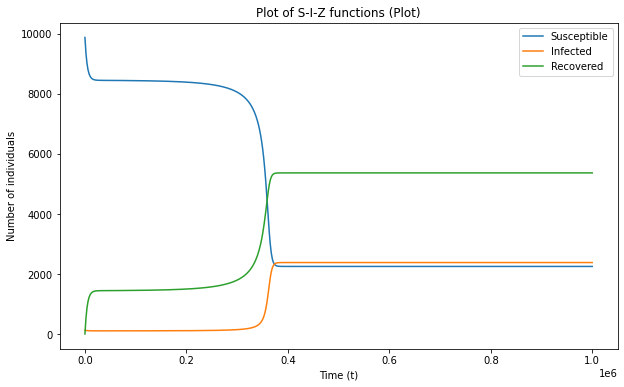

Final stable equilibrium i^* = 0.23809938298644015


In [3]:
# Initial parameters
mu = 0.00015
gamma = 0.0027
beta = 0.00096
phi = 0.0044

kappa = 0.8  #C^I/C^S
theta = 1.7 #C^Z/C^S

# R values:
Rmu = mu/(mu+ gamma)
Rphi = phi/(mu + gamma)

R0 = 1.0105263157894737  # R0 = beta*Ci/(gamma+mu)  -> beta = R0*(gamma+mu)/Ci
print(R0*(gamma+mu)/3)

print(f"""
Parameters:
mu : {mu}
gamma: {gamma}
beta : {beta}
phi: {phi}
Rmu = {Rmu}
Rphi = {Rphi}
""")

# Number for three roots condition: (Theorem)
print(f"""
Multiple roots condition satisfied:
{Rphi - (Rmu**2 + 1)/(Rmu**2 - 2*Rmu + 1) > 0}
""")

Ci = 3
Cs = Ci/kappa
Cz = Cs*theta

print(f"""Contact rates per group:
Cs = {Cs}
Ci = {Ci}
Cz = {Cz}
""")

R0 = Ci*beta/(gamma+mu)
roots = poly_utils.solve_polynomial(Rphi, Rmu, R0, kappa, theta)

print(f"""
R0 value: {R0}
kappa: {kappa}
theta: {theta}

Theoretical Possible Equilibria Roots:
{roots}
""")

x00 = [9880,119,1]
t_max = 1000000
print(' --- Model Simulation ---')
print(f'i(0) : {x00[1]/sum(x00)}')
non_adaptive = NonAdaptive(mu, gamma, beta, phi, Cs, Ci, Cz, x00, t_max, dt=0.1)
non_adaptive.solve_odes_system(method='odeint')
non_adaptive.plot_ode_solution()
print(f'Final stable equilibrium i^* = {non_adaptive.I[len(non_adaptive.I) - 1]/sum(x00)}')

## Equilibria points attained

Obtain the limit in infected population for each combination of initial values $x_0$

In [27]:
t_max = 100000
poly_utils.get_convergence_point(10000, 1, 0.02,
                      mu, gamma, beta, phi,
                      Cs, Ci, Cz, t_max)

0.23809922266046582

Plot and wiring data for Figure 3 in article

(200, 10)


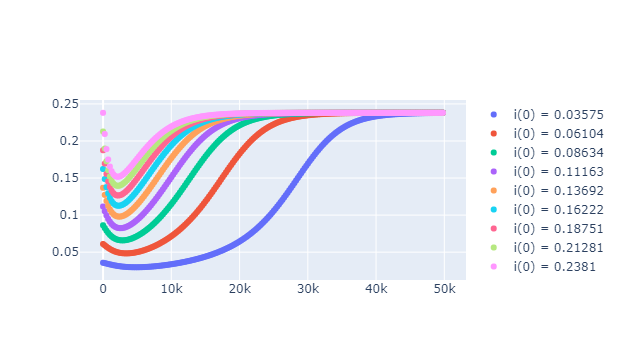

In [28]:
# init_i_props = np.linspace(0.0001, 0.010455203872732766, 10)
init_i_props = np.linspace(0.010455203872732766, 0.23809938298643937, 10)

N = 10000
recovered = 10
Is = []
t_max = 50000

for init_prop in init_i_props:
    initial_infected = math.floor(init_prop*N)
    x00 = [N - initial_infected - recovered, initial_infected, recovered]
    non_adaptive = NonAdaptive(mu, gamma, beta, phi, Cs, Ci, Cz, x00, t_max, dt=0.1)
    non_adaptive.solve_odes_system(method='odeint')
    I_raw = non_adaptive.I
    I_scaled = [i/N for i in I_raw]
    Is.append(I_scaled)

data = pd.DataFrame({
    't': np.linspace(0,t_max,len(Is[0]))
})

for k in range(1,len(Is)):
    data[f'y{k}'] = [round(val,5) for val in Is[k]]

data = data.iloc[list(range(0, data.shape[0], 5))]
print(data.shape)

fig = go.Figure()

# Add traces
for k in range(1,len(Is)):
    fig.add_trace(go.Scatter(x=data['t'], y=data[f'y{k}'],
                        mode='markers',
                        name=f'i(0) = {round(init_i_props[k],5)}'))
    
# Write for LaTeX table
# data = data.astype(str)
# data_latex = ''

# for j in range(data.shape[0]):
#     row = data.iloc[j]
#     data_latex = data_latex + '\n' + ' '.join(row.tolist())
    
# file = open('dat_eq1.txt','w+')
# file.write(' '.join(data.columns.tolist()))
# file.write(data_latex)
# file.close()

fig.show()

### Effect of $(\kappa, \theta)$

Final convergence point depends inversely on the size of $\kappa$.
Similar thing happens for $\theta$. We make a 3D surface plot to inspect the effect of both $\kappa$ and $\theta$.

In [29]:
kappas = np.linspace(0.02,1,50)
thetas = np.linspace(0.04,2,50)

init_prop_inf =  0.09
Ci = 3
t_max = 5000000

# As DataFrame
eqpointsdf = pd.DataFrame({})   
combinations = []      
for kappa in kappas:
    for theta in thetas:        
        combinations.append((round(kappa,2),round(theta,2)))

for comb in tqdm(combinations):

    kappa = comb[0]
    theta = comb[1]
    
    Cs = Ci/kappa
    Cz = Cs*theta

    conv_point = poly_utils.get_convergence_point(
        10000, 1, init_prop_inf, mu, gamma, beta, phi, Cs, Ci, Cz, t_max)
    
    try:
        # max_root = max(roots)
        eqpointsdf= eqpointsdf.append(pd.DataFrame({
            'kappa':[kappa],
            'theta':[theta],
            'conv_point':[conv_point]
        }),ignore_index=True)
        
    except:
        pass

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 422.71it/s]


Data Frame with equilibrium point obtained for each $(\kappa,\theta)$ conmbination, with $x_0$ and $R_0(C^i)$ fixed.

In [30]:
# min_conv_point = min(eqpointsdf['conv_point'])
# eqpointsdf[eqpointsdf['conv_point'] == min_conv_point]
eqpointsdf.head(2)

,kappa,theta,conv_point
0,0.02,0.04,0.427376
1,0.02,0.08,0.424502


Convergence of classical model:

In [31]:
eqpointsdf[(eqpointsdf['kappa']==1) & (eqpointsdf['theta']==1)]

,kappa,theta,conv_point
2474,1.0,1.0,0.301368


In [32]:
eqpointsdf_vals = eqpointsdf.pivot(index='kappa', columns='theta', values='conv_point').reset_index()##.set_index('column_name')
eqpointsdf_vals.index = eqpointsdf_vals['kappa'].tolist()
eqpointsdf_vals = eqpointsdf_vals.drop(['kappa'], axis=1)
eqpointsdf_vals.head(5)

theta,0.04,0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,...,1.64,1.68,1.72,1.76,1.80,1.84,1.88,1.92,1.96,2.00
0.02,0.427376,0.424502,0.421610,0.418700,0.415771,0.412823,0.409855,0.406867,0.403858,0.400828,...,0.290112,0.285628,0.281038,0.276336,0.271508,0.266543,0.261426,0.256139,0.250660,0.244963
0.04,0.426300,0.423426,0.420534,0.417624,0.414695,0.411747,0.408779,0.405791,0.402782,0.399751,...,0.288942,0.284447,0.279847,0.275131,0.270290,0.265310,0.260175,0.254868,0.249365,0.243640
0.06,0.425226,0.422352,0.419461,0.416551,0.413622,0.410674,0.407706,0.404717,0.401708,0.398677,...,0.287773,0.283268,0.278656,0.273929,0.269073,0.264077,0.258924,0.253596,0.248070,0.242317
0.08,0.424155,0.421282,0.418390,0.415480,0.412551,0.409603,0.406635,0.403646,0.400637,0.397606,...,0.286605,0.282090,0.277468,0.272727,0.267858,0.262845,0.257674,0.252325,0.246774,0.240993
0.10,0.423087,0.420213,0.417322,0.414412,0.411483,0.408535,0.405567,0.402578,0.399568,0.396537,...,0.285440,0.280914,0.276280,0.271527,0.266643,0.261615,0.256425,0.251054,0.245479,0.239668


<AxesSubplot:xlabel='theta'>

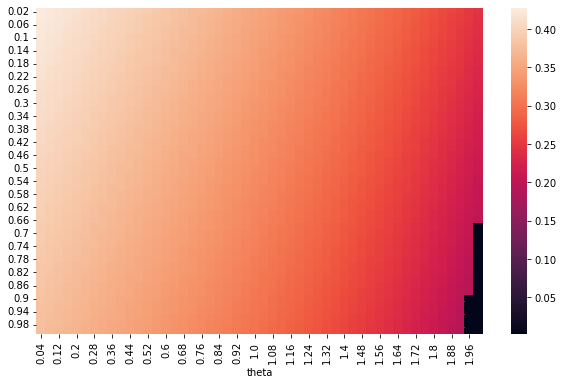

In [33]:
sns.heatmap(eqpointsdf_vals, annot=False)

### Surface plot
Varying $\kappa$ and $\theta$, fixing $R_0$ ($C^i$).
For each combination we obtain the equilibrium point attained.

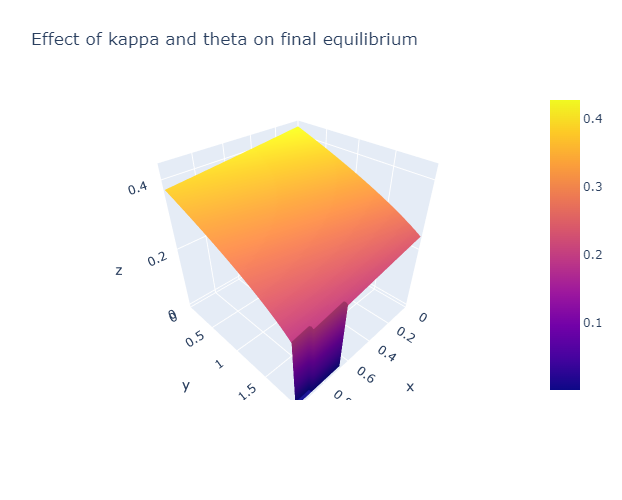

In [34]:
z_data = eqpointsdf_vals.values.T
x, y = np.linspace(0.02,1,50), np.linspace(0.04,2,50)
fig = go.Figure(data=[go.Surface(z=z_data, x=x, y=y)])
fig.update_layout(title='Effect of kappa and theta on final equilibrium', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=100, t=90),
                 scene = dict(
                     xaxis = dict(nticks=7, range=[0,1],),
                     yaxis = dict(nticks=7, range=[0,2],),
                     ),
                 )
fig.show()

We can see that increasing the values of $(\kappa,\theta)$ leads to lower equilibrium points.
At a at high values of $\kappa$ the equilibrium attained is the semi-disease-free case.

In [123]:
# To create the variable in matlab. to plot #
# z_data_matlab = '['
# for row in z_data:
#     row_str = [str(r) for r in row]
#     z_data_matlab = z_data_matlab+','.join(row_str)+';\n'
# z_data_matlab = z_data_matlab + ']'
# print(z_data_matlab)

## Region $\mathcal{R_3}$ window
Computations done in parallel. Look `computeR3window.py`. \
This is for section 4.2 of article manuscript.

In [35]:
r3windowdf = pd.read_csv("C:/Users/jimmy/OneDrive/Desktop/Maestria Metodos Matematicos y Aplicaciones/Tesis/adaptive/code/disaggregated/data/article_data/r3windowdf.csv")
r3windowdf

,kappa,theta,R0,num_roots
0,0.05,0.05,1.000000,1
1,0.05,0.05,1.000302,1
2,0.05,0.05,1.000603,1
3,0.05,0.05,1.000905,1
4,0.05,0.05,1.001206,1
...,...,...,...,...
159995,1.00,2.00,1.058794,3
159996,1.00,2.00,1.059095,1
159997,1.00,2.00,1.059397,1
159998,1.00,2.00,1.059698,1


In [36]:
combs_R3 = r3windowdf[r3windowdf['num_roots']==3][['kappa','theta']].drop_duplicates().reset_index(drop=True)
combs_R3.shape

(205, 2)

In [37]:
R0window_max = []

for i in tqdm(range(combs_R3.shape[0])):
    row = combs_R3.iloc[i]
    kappa = row['kappa']
    theta = row['theta']
    r3windowdf_fil = r3windowdf[(r3windowdf['num_roots']==3) & (r3windowdf['kappa']==kappa) & (r3windowdf['theta']==theta)]
    R0_max = r3windowdf_fil['R0'].max()
    R0window_max.append(R0_max)

r3windowdf_plot = pd.DataFrame({
    'kappa': combs_R3['kappa'].tolist(),
    'theta': combs_R3['theta'].tolist(),
    'R0_max': R0window_max
})

r3windowdf_plot

100%|███████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 730.31it/s]


,kappa,theta,R0_max
0,0.05,1.55,1.000000
1,0.05,1.60,1.000905
2,0.05,1.65,1.003317
3,0.05,1.70,1.006935
4,0.05,1.75,1.011457
...,...,...,...
200,1.00,1.80,1.025628
201,1.00,1.85,1.033166
202,1.00,1.90,1.041005
203,1.00,1.95,1.049749


In [38]:
r3windowdf_vals = r3windowdf_plot.pivot(index='kappa', columns='theta', values='R0_max').reset_index()##.set_index('column_name')
r3windowdf_vals.index = r3windowdf_vals['kappa'].tolist()
r3windowdf_vals = r3windowdf_vals.drop(['kappa'], axis=1)
r3windowdf_vals.head(5)

theta,1.5,1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9,1.95,2.0
0.05,NaN,1.0,1.000905,1.003317,1.006935,1.011457,1.016884,1.022915,1.029849,1.037387,1.045226
0.10,NaN,1.0,1.000905,1.003618,1.007236,1.011759,1.017186,1.023518,1.030452,1.037990,1.045829
0.15,NaN,1.0,1.001206,1.003618,1.007538,1.012060,1.017789,1.024121,1.031055,1.038593,1.046432
0.20,NaN,1.0,1.001206,1.003920,1.007839,1.012362,1.018090,1.024422,1.031357,1.039196,1.047035
0.25,NaN,1.0,1.001508,1.004221,1.008141,1.012965,1.018693,1.025025,1.031960,1.039799,1.047940


<AxesSubplot:xlabel='theta'>

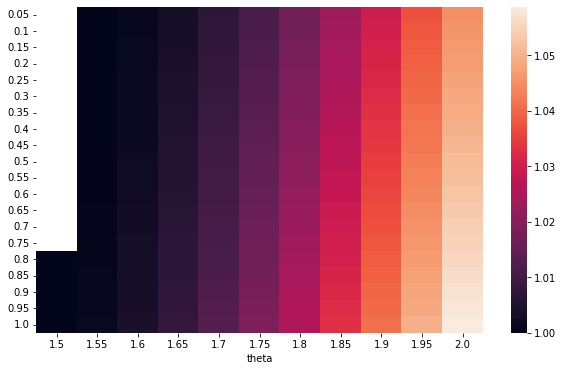

In [39]:
sns.heatmap(r3windowdf_vals, annot=False)

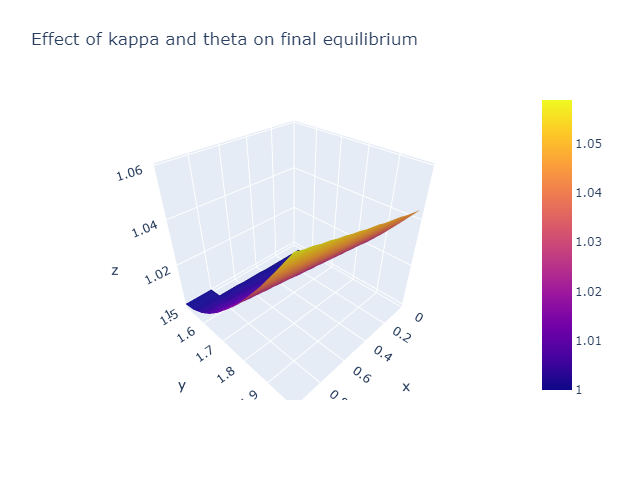

In [40]:
z_data_r3windowdf = r3windowdf_vals.values.T
fig = go.Figure(data=[go.Surface(z=z_data_r3windowdf, x=r3windowdf_vals.index, y=r3windowdf_vals.columns)])
fig.update_layout(title='Effect of kappa and theta on final equilibrium', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=100, t=90),
                 scene = dict(
                     xaxis = dict(nticks=7, range=[0,1],),
                     yaxis = dict(nticks=7, range=[1.5,2],),
                     ),
                 )
fig.show()

In [41]:
# To create the variable in matlab. for plot in article manuscript #
# z_data_matlab = '['
# for row in z_data_r3windowdf:
#     row_str = [str(r) for r in row]
#     z_data_matlab = z_data_matlab+','.join(row_str)+';\n'
# z_data_matlab = z_data_matlab + ']'
# z_data_matlab = z_data_matlab.replace('nan','1.0')
# print(z_data_matlab)
# print(f"x3= {r3windowdf_vals.index.tolist()};")
# print(f"y3= {r3windowdf_vals.columns.tolist()};")